# Validation Set 1 on Kegg 

In [1]:
import os
import time

import itertools
from collections import defaultdict


from openpyxl import load_workbook
import networkx as nx

##### PyBEL imports

In [2]:
import pybel
import pybel_tools as pbt

from pybel import BELGraph
from pybel.constants import RELATION, ANNOTATIONS
from pybel.dsl import Abundance, BiologicalProcess, CentralDogma, ListAbundance, Reaction
from pybel.struct import get_subgraph_by_annotation_value
from pybel.struct.summary import count_functions

pybel.get_version()

'0.13.2'

##### PathMe import 

In [3]:
from pathme.constants import REACTOME_BEL, KEGG_BEL, WIKIPATHWAYS_BEL, PATHME_DIR
from pathme.export_utils import to_gml

##### DiffuPy import 

In [4]:
import diffupy
from diffupy.kernels import regularised_laplacian_kernel

##### DiffuPath import 

In [5]:
import diffupath

from diffupath.constants import DATA_DIR
from diffupath.validation_datasets_parsers import parse_set1

from diffupath.pathme_importer import get_labels_by_db_and_omic_from_pathme, get_labels_by_db_and_omic_from_graph
from diffupath.input_mapping import get_mapping, get_mapping_subsets, get_mapping_two_dim_subsets
from diffupath.utils import print_dict_dimensions, get_labels_set_from_dict, reduce_dict_dimension, get_count_and_labels_from_two_dim_dict, from_pickle, to_pickle
from diffupath.views import show_heatmap



## 1. Load Data Set 1: Input Scores

In [6]:
dataset1_labels_by_omics = parse_set1(os.path.join(DATA_DIR, 'validation_datasets', 'set1.xlsx'))
dataset1_all_labels = get_labels_set_from_dict(dataset1_labels_by_omics)
print_dict_dimensions(dataset1_labels_by_omics, 'Dataset1 imported labels:')

Dataset1 imported labels:
Total number of genes: 4941  
Total number of micrornas: 100  
Total number of metabolite: 21  
Total: 5062 


In [7]:
mirnas_dataset =  dataset1_labels_by_omics['micrornas']

## 2. Load KEGG Backrgound Network

### 2.1. Import PathMeUniverse graph

In [8]:
pathme_universe_graph_no_flatten = pybel.from_pickle(os.path.join(PATHME_DIR, 'universe', 'pathme_universe_bel_graph_no_flatten.bel.pickle'))
pathme_universe_graph_no_flatten.summarize()

PathMe Universe v1.0.0
Number of Nodes: 48643
Number of Edges: 104713
Number of Citations: 7696
Number of Authors: 0
Network Density: 4.43E-05
Number of Components: 6860
Number of Warnings: 0


##### Check and filter isolates / Unconnected nodes

In [9]:
nx.number_of_isolates(pathme_universe_graph_no_flatten)

6426

In [11]:
pathme_universe_graph_no_flatten.remove_nodes_from({
    node
    for node in nx.isolates(pathme_universe_graph_no_flatten)
})

### 2.2. Get KEGG subgraph from PathMeUniverse graph

In [12]:
kegg_pathme_graph_no_flatten = get_subgraph_by_annotation_value(pathme_universe_graph_no_flatten, 'database', 'kegg')
kegg_pathme_graph_no_flatten.summarize()
count_functions(kegg_pathme_graph_no_flatten)

None vNone
Number of Nodes: 13162
Number of Edges: 35122
Number of Citations: 2
Number of Authors: 0
Network Density: 2.03E-04
Number of Components: 65
Number of Warnings: 0


Counter({'Composite': 1596,
         'Complex': 406,
         'Gene': 6149,
         'Abundance': 1762,
         'Reaction': 3137,
         'BiologicalProcess': 112})

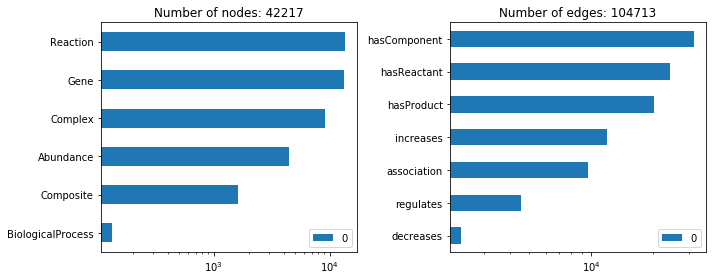

In [13]:
import matplotlib.pyplot as plt
from pybel_tools.summary import plot_summary, count_top_centrality
plot_summary(kegg_pathme_graph_no_flatten, plt, figsize=(10, 4))
plt.show()

### 2.3. Get entity labels subsets by entity type (omic) and by database

#####  2.3.1. From PathMe package subsets

In [14]:
bg_labels_from_pathme_by_db_and_omic, bg_labels_from_pathme_by_omic_and_db = get_labels_by_db_and_omic_from_pathme(['reactome', 'kegg', 'wikipathways'])

print_dict_dimensions(bg_labels_from_pathme_by_db_and_omic, 'Entities in PathMe package :')


Entities in PathMe package :
Total number of reactome: genes(8653), mirna(13), metabolites(2712), bps(2219),  
Total number of kegg: genes(7656), mirna(149), metabolites(4421), bps(418),  
Total number of wikipathways: genes(3361), mirna(91), metabolites(657), bps(135),  
Total: 30485 


In [15]:
bg_labels_from_pathme_by_omic = reduce_dict_dimension(bg_labels_from_pathme_by_omic_and_db)

#####  2.3.2.  From PathMeUniverse KEGG subgraph

In [16]:
bg_labels_from_pathmeuniverse_by_db_and_omic, bg_labels_from_pathmeuniverse_by_omic_and_db =  get_labels_by_db_and_omic_from_graph(pathme_universe_graph_no_flatten)

print_dict_dimensions(bg_labels_from_pathmeuniverse_by_db_and_omic, 'Entities in PathMeUniverse :')

Entities in PathMeUniverse :
Total number of kegg: gene_nodes(6027), mirna_nodes(122), metabolite_nodes(1762), bp_nodes(112),  
Total number of reactome: gene_nodes(8615), mirna_nodes(13), metabolite_nodes(2684), bp_nodes(5),  
Total number of wikipathways: gene_nodes(2549), mirna_nodes(91), metabolite_nodes(618), bp_nodes(152),  
Total: 22750 


In [17]:
bg_labels_from_pathmeuniverse_by_omic = reduce_dict_dimension(bg_labels_from_pathmeuniverse_by_omic_and_db)

### 2.4. Get Background  Matrix Kernel

In [18]:
kernel_path = os.path.join(DATA_DIR, 'pickles', 'by_db_validation', 'regularised_laplacian_kernel_kegg.pickle')

##### Generate kernel OR load from pickle

In [19]:
#background_mat = regularised_laplacian_kernel(kegg_pathme_graph_no_flatten)
#to_pickle(regularised_laplacian_kernel, kernel_path)

In [20]:
background_mat = from_pickle(kernel_path)

## 3. Dataset label mapping to PathMeEntities

##### All kernel matrix (background network) row labels for the mapping

In [21]:
background_labels = background_mat.rows_labels

### 3.1. General mapping

In [22]:
all_labels_mapping = get_mapping(dataset1_all_labels, background_labels, title = 'Global mapping: ', mirnas = mirnas_dataset, print_percentage = True)


Global mapping:  (1627) 32.141446068747534%


### 3.2. Mapping by subsets

#### 3.2.1. Mapping by entity type/omic

In [23]:
mapping_by_entity, _, _ = get_mapping_subsets(dataset1_labels_by_omics, background_labels, 'entity type/omic', mirnas = mirnas_dataset)


Mapping by entity type/omic:
genes (1619) 32.76664642784861%
micrornas (14) 14.000000000000002%
metabolite (8) 38.095238095238095%
Total (1641) 32.41801659423153% 



In [24]:
micrornas_mapping = mapping_by_entity['micrornas'][0]

#### 3.2.2. Mapping by database

In [25]:
background_entites_by_db = {db : set(itertools.chain.from_iterable(entities.values())) for db, entities in bg_labels_from_pathmeuniverse_by_db_and_omic.items()}
mapping_by_db, _, _ = get_mapping_subsets(background_entites_by_db, dataset1_all_labels, 'database', mirnas = mirnas_dataset, submapping = background_labels, mirnas_mapping = micrornas_mapping, percentage_reference_labels = True)


Mapping by database:
kegg (1641) 32.41801659423153%
reactome (628) 12.406163571710787%
wikipathways (604) 11.932042670881076%
Total (1641) 32.41801659423153% 



#### 3.2.3. Mapping by entity type and database (two dimentions)

In [26]:
mapping_by_database_and_entity, total_percentage, total_dimention = get_mapping_two_dim_subsets(bg_labels_from_pathmeuniverse_by_db_and_omic, dataset1_all_labels, relative_statistics = dataset1_labels_by_omics, mirnas_mapping = micrornas_mapping)


Mapping by Kegg:
gene_nodes (1615) 32.68569115563651%
mirna_nodes (14) 14.000000000000002%
metabolite_nodes (12) 57.14285714285714%
bp_nodes (0) 0%
Total (1641) 20.4536956250779% 

Mapping by Reactome:
gene_nodes (1259) 25.480671928759364%
mirna_nodes (2) 2.0%
metabolite_nodes (12) 57.14285714285714%
bp_nodes (0) 0%
Total (1273) 11.24856410709552% 

Mapping by Wikipathways:
gene_nodes (775) 15.68508399109492%
mirna_nodes (9) 9.0%
metabolite_nodes (18) 85.71428571428571%
bp_nodes (1) 0%
Total (803) 23.548387096774192% 

Total (2420) 47.80719083366258% 



### 3.3. Mapping descriptive view

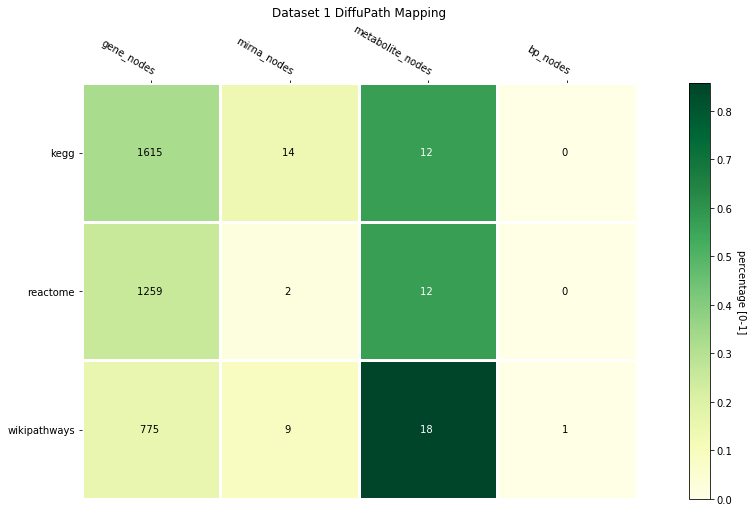

In [27]:
count, percentage, db_labels, entity_labels  = get_count_and_labels_from_two_dim_dict(mapping_by_database_and_entity)

show_heatmap(count, percentage, db_labels, entity_labels)


## 4. Cross-validation

In [27]:
from diffupath.views import box_plot_from_dict
from diffupath.cross_validation import cross_validation_by_subset_same_diff_input, cross_validation_by_method

### 4.1. Random Scheme

#### 4.1.1.  By method

In [28]:
auroc_metrics_by_method, auprc_metrics_by_method = cross_validation_by_method(all_labels_mapping, kegg_pathme_graph_no_flatten, background_mat, k=10)


100%|██████████| 10/10 [01:11<00:00,  7.04s/it]


In [30]:
box_plot_from_dict(auroc_metrics_by_method, 'Random Cross Validation', 'Method type', 'AUROC')

/usr/local/Cellar/ipython/7.2.0/libexec/lib/python3.7/site-packages/IPython/core/display.py:689: UserWarning:

Consider using IPython.display.IFrame instead



In [31]:
box_plot_from_dict(auprc_metrics_by_method, 'Random Cross Validation', 'Method type', 'AUROC')

#### 5.1.2.  By entity

In [32]:
auroc_metrics_by_entity, auprc_metrics_by_entity = cross_validation_by_subset_same_diff_input(mapping_by_entity, background_mat, k = 10)


100%|██████████| 10/10 [00:44<00:00,  4.38s/it]


In [33]:
box_plot_from_dict(auroc_metrics_by_entity, 'Random Cross Validation', 'Entity type', 'AUROC')


/usr/local/Cellar/ipython/7.2.0/libexec/lib/python3.7/site-packages/IPython/core/display.py:689: UserWarning:

Consider using IPython.display.IFrame instead



In [34]:
box_plot_from_dict(auprc_metrics_by_entity, 'Random Cross Validation', 'Entity type', 'AUPRC')